# Análisis de Posiciones del aborto en Twitter
## Laboratorio 2 <br>
<br>
Grupo: Aballay, Avedaño, Garnica <br>

El práctico comienza con la limpieza de datos, verificando que el dataset cumpla con el checklist del Banco Mundial, luego analiza los principales hashtags y su posición frente a la sanción de la ley. Por último, se realiza un primer intento de clasificación del texto de los tweets en base a la presencia de hashtags y emojis y una nube de palabras con los principales términos incluídos en el cuerpo del tweet.

In [4]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(knitr)
library(stringi)
library(rvest)
library(stringr)
library(utf8)
library(RColorBrewer)
library(data.table)
library(digest)
library(wordcloud)
library(tm)

options(scipen=999)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: xml2
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

Warning message:
"package 'wordcloud' was built under R version 3.6.1"Warning message:
"package 'tm' was built under R version 3.6.1"Loading required package: NLP

Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate



In [5]:
###1- Union de bases de Tweets
#Cambiar la ruta del archivo

ruta <- "C:/Users/User02/Google Drive/DiploDatos/Mentoria/"

tweets_junio <- read.csv(paste(ruta, "tweets_junio.csv", sep=""), 
                         encoding = 'UTF-8')

tweets_ago <- read.csv(paste(ruta, "tweets_agosto.csv", sep =""), 
                       encoding = 'UTF-8')

tweets_junio$base <- "06_Junio"
tweets_ago$base <- "08_Agosto"
tweets_ago$posicion <- NA
colnames(tweets_ago)[5]<-"full_text"

tweets <- rbind(tweets_ago, tweets_junio)

# 1 - Limpieza de Datos

Comprobarmos que el dataset cumpla con el checklist del Banco Mundial:

1. Before data cleaning: Importing the data<br>
1.1	Check for importing issues such as broken lines when importing .csv files<br>
1.2	Make sure you have unique IDs<br>
1.3	De-identify all data and save in a new .dta file<br>
1.4	Never make any changes to the raw data<br>
2. Important steps for data cleaning<br>
2.1	Label variables, don’t use special characters<br>
2.2	Recode and label missing values: your data set should not have<br>
2.3	Encode variables: all categorical variables should be saved as labeled numeric variables, no strings<br>
2.4	Don’t change variable names from questionnaire, except for nested repeat groups and reshaped roster data<br>
2.5	Check sample representativeness of age, gender, urban/rural, region and religion<br>
2.6	Check administrative data such as date, time, interviewer variables included<br>
2.7	Test variables consistency<br>
2.8	Identify and document outliers<br>
2.9	Compress dataset so it is saved in the most efficient format<br>
2.10 Save cleaned data set with an informative name. Avoid saving in a very recent Stata version<br>
3. Optional steps in data cleaning<br>
3.1	Order variables – unique ID always first, then same order as questionnaire<br>
3.2	Drop variables that only make sense for questionnaire review (duration, notes, calculates)<br>
3.3	Rename roster variables<br>
3.4	Categorize variables listed as “others”<br>
3.5	Add metadata as notes: original survey question, relevance, constraints, etc<br>

Aplicando cada punto a la base de tweets: <br>
1.1	Check for importing issues such as broken lines when importing .csv files<br>
<br>
No se verifican lineas rotas/cortadas, en caso de existir, R avisa con Warnings al momento de la apertura.

In [6]:
# 1.2	Make sure you have unique IDs
#Elimino duplicados. Verifico cantidad de ids únicos

length(unique(tweets$id))

[1] 1162136

In [7]:
duplicados <- tweets %>%
  group_by(id) %>%
  mutate(cant = n()) %>%
  filter(cant > 1)
length(unique(duplicados$id))

[1] 351

In [8]:
tweets <- tweets %>%
  distinct(id, .keep_all = TRUE)
length(unique(tweets$id))

[1] 1162136

Se verfica la existencia de 351 tweets de duplicados por id. Eliminando los casos duplicados la base queda con 1.162.136 tweets distintos.
Para el análisis de palabras también se decidió excluir lor retweets. En el práctico 1, se había observado que la variable retweet no identificaba claramente este tipo de mensajes por lo que se decidió identificarlos de acuerdo a si el cuerpo del texto comienza o no con las siglas "RT".

In [9]:
#Retweets
tweets$full_text <- as.character(tweets$full_text)
tweets$rt <- ifelse(substr(tweets$full_text, 1, 2) == "RT", 1, 0)
table(tweets$rt, useNA = "always")

#961.095 rt (82,3%)
# text_dup <- tweets %>%
#   group_by(full_text) %>%
#   mutate(cant = n()) %>%
#   filter(cant > 1)

tweets <- tweets[tweets$rt == 0, ]


     0      1   <NA> 
201041 961095      0 

Existen 961.095 registros identificados como retweet que son eliminados de la base.

In [11]:
# 1.3	De-identify all data and save in a new .dta file
# 1.4	Never make any changes to the raw data
save(tweets, file = paste(ruta, "base_tweets.Rda", sep=""))

In [8]:
# 2.1	Label variables, don’t use special characters
colnames(tweets)
head(tweets)

[1] "id"             "created_at"     "favorite_count" "retweet_count" 
 [5] "full_text"      "favorited"      "retweeted"      "user_name"     
 [9] "user_id"        "original_id"    "base"           "posicion"      
[13] "rt"

,id,created_at,favorite_count,retweet_count,full_text,favorited,retweeted,user_name,user_id,original_id,base,posicion,rt
1,1025181421961392128,Fri Aug 03 00:47:52 +0000 2018,0,0,<U+0001F539> 5 Mitos sobre el aborto que todos debemos saber [VÍDEO] https://t.co/QVLOyPu7tu,False,False,Revista Digital,2208347839,1025181421961392128,08_Agosto,NA,0
3,1025181423639113728,Fri Aug 03 00:47:53 +0000 2018,0,0,El aborto que se perdió tu vieja jajajajajajajajajajjajajajaja,False,False,Delfina<U+0001F49A>,984930721373573120,1025181423639113728,08_Agosto,NA,0
9,1025181430807257088,Fri Aug 03 00:47:54 +0000 2018,0,0,"Ahre lxs ""provida"" dicen ""cuidemos las dos vidas"" y se la pasan agrediendo",False,False,Mmeli<U+0001F4B8>,930515694281809920,1025181430807257088,08_Agosto,NA,0
14,1025181440240173056,Fri Aug 03 00:47:56 +0000 2018,0,0,Menos mal q se dice ateo,False,False,L U <U+0001F1E6><U+0001F1F7> <U+0001F339>,2290409972,1025181440240173056,08_Agosto,NA,0
26,1025181466093920256,Fri Aug 03 00:48:03 +0000 2018,0,0,Lista de argumentos de Amalia Granata en contra de la legalización del aborto: -Es un ser humano -Es un bebé -Vas a… https://t.co/z0skBhmGiH,False,False,Tomi,1015076557956710400,1025181466093920256,08_Agosto,NA,0
27,1025181466408505344,Fri Aug 03 00:48:03 +0000 2018,0,0,@RomeroxSalta Gracias Senador!! Argentina se lo agradece! #SalvemosLasDosVidas #RechazoTotalYa,False,False,Mariana Sosa,1011013119970304000,1025181466408505344,08_Agosto,NA,0


In [12]:
# 2.2	Recode and label missing values: your data set should not have 
#observations with -777, -88 or -9 values, for example
summary(tweets[, c(1,3,4,6,7,9,10)])

#No se verifican valores negativos, ni valores faltantes

       id                      favorite_count     retweet_count      
 Min.   :1004513269960000000   Min.   :    0.00   Min.   :    0.000  
 1st Qu.:1006334464880000000   1st Qu.:    0.00   1st Qu.:    0.000  
 Median :1006927233860000000   Median :    1.00   Median :    0.000  
 Mean   :1009214630600000000   Mean   :   11.03   Mean   :    3.984  
 3rd Qu.:1007304364360000000   3rd Qu.:    3.00   3rd Qu.:    1.000  
 Max.   :1025420281740000000   Max.   :51902.00   Max.   :25144.000  
 favorited      retweeted         user_id                   
 False:201041   False:201041   Min.   :             719413  
                               1st Qu.:          205313045  
                               Median :          884132780  
                               Mean   : 205974395844000000  
                               3rd Qu.:         4164997133  
                               Max.   :1025411441240000000  
  original_id                 
 Min.   :1004513269960000000  
 1st Qu.:100633446488

In [13]:
# 2.3	Encode variables: all categorical variables should be saved as labeled numeric variables, no strings
str(tweets)

'data.frame':	201041 obs. of  13 variables:
 $ id            : num  1025181421961392128 1025181423639113728 1025181430807257088 1025181440240173056 1025181466093920256 ...
 $ created_at    : Factor w/ 489099 levels "Fri Aug 03 00:47:52 +0000 2018",..: 1 2 3 5 11 11 12 14 21 21 ...
 $ favorite_count: int  0 0 0 0 0 0 0 0 0 0 ...
 $ retweet_count : int  0 0 0 0 0 0 0 0 0 0 ...
 $ full_text     : chr  "<U+0001F539> 5 Mitos sobre el aborto que todos debemos saber [VÍDEO] https://t.co/QVLOyPu7tu" "El aborto que se perdió tu vieja jajajajajajajajajajjajajajaja" "Ahre lxs \"provida\" dicen \"cuidemos las dos vidas\" y se la pasan agrediendo" "Menos mal q se dice ateo" ...
 $ favorited     : Factor w/ 1 level "False": 1 1 1 1 1 1 1 1 1 1 ...
 $ retweeted     : Factor w/ 1 level "False": 1 1 1 1 1 1 1 1 1 1 ...
 $ user_name     : Factor w/ 300553 levels "","'","'' Gonzaa ''",..: 53359 20044 45823 35042 59600 42068 39761 11075 37546 14427 ...
 $ user_id       : num  2208347839 984930721373573120

se verifica que no se reconocieron correctamente los tipos de las siguientes variables:<br>
created_at<br>
favorited<br>
retweeted<br>

In [14]:
#Fecha
tweets$created_at <- as.character(tweets$created_at)
Sys.setlocale("LC_TIME", "English")
tweets$fecha <- as.POSIXct(tweets$created_at, format="%a %b %d %H:%M:%S +0000 %Y", tz="GMT")

#Numéricas
tweets$favorited <- as.numeric(tweets$favorited)
tweets$retweeted <- as.numeric(tweets$retweeted)
tweets$user_name <- as.character(tweets$user_name)

[1] "English_United States.1252"

In [15]:
# 2.4	Don’t change variable names from questionnaire, except for nested repeat groups and reshaped roster data
#No aplica
# 2.5	Check sample representativeness of age, gender, urban/rural, region and religion
#No aplica
# 2.6	Check administrative data such as date, time, interviewer variables included
summary(tweets$fecha)

                 Min.               1st Qu.                Median 
"2018-06-07 00:00:01" "2018-06-12 00:36:47" "2018-06-13 15:52:15" 
                 Mean               3rd Qu.                  Max. 
"2018-06-19 23:21:32" "2018-06-14 16:50:49" "2018-08-03 16:37:01" 

La variable fecha ha quedado correctamente epecificada, sin valores vacíos o nulos y con los valores minimos y máximos correctos de acuerdo a las fechas de extracción de las bases.

In [16]:
# 2.7	Test variables consistency
# 2.8	Identify and document outliers
# 2.9	Compress dataset so it is saved in the most efficient format
# 2.10	Save cleaned data set with an informative name. Avoid saving in a very recent Stata version
save(tweets, file = "C:/Mentoria/AbortoTwitter/base_tweets.Rda")

In [17]:
# 3. Optional steps in data cleaning
# 3.1	Order variables – unique ID always first, then same order as questionnaire
# 3.2	Drop variables that only make sense for questionnaire review (duration, notes, calculates)
# 3.3	Rename roster variables
# 3.4	Categorize variables listed as “others”
# 3.5	Add metadata as notes: original survey question, relevance, constraints, etc

# 2 - Extracción de Hashtags

Se extraen todos los hashtags de los cuerpos de texto, luego se analizan los más usados y se los clasifica de acuerdo a si se encuentran a favor o no de la ley de interrupción voluntaria del embarazo.

In [19]:
extrae.hash = function(vec){
  hash.pattern = "#[[:alnum:]]+"
  have.hash = grep(x = vec, pattern = hash.pattern)
  hash.matches = gregexpr(pattern = hash.pattern, text = vec[have.hash])
  extracted.hash = regmatches(x = vec[have.hash], m = hash.matches)
  df = data.frame(table(tolower(unlist(extracted.hash))))
  colnames(df) = c("tag","freq")
  df = df[order(df$freq,decreasing = TRUE),]
  return(df)
}

hash <- extrae.hash(tweets$full_text)

hashtags <- as.data.frame(str_extract_all(tweets$full_text, "#\\S+", simplify = T))

In [20]:
#Se define la posición del hash:
#1-A favor de la Ley
#2-En contra de la Ley

hash$tag <- as.character(hash$tag)
hash$tag <- trimws(hash$tag, "both")
#hash$tag <- paste(hash$tag, " ", sep = "")

hash$pos[hash$tag == "#abortolegalya"] <- 1
hash$pos[hash$tag == "#abortolegal"] <- 1
hash$pos[hash$tag == "#salvemoslas2vidas"] <- 2
hash$pos[hash$tag == "#noalabortoenargentina"] <- 2
hash$pos[hash$tag == "#quesealey"] <- 1
hash$pos[hash$tag == "#argentinaesprovida"] <- 2
hash$pos[hash$tag == "#noalaborto"] <- 2
hash$pos[hash$tag == "#queelabortosealey"] <- 1
hash$pos[hash$tag == "#abortosesionhistorica"] <- 0
hash$pos[hash$tag == "#abortoseraley"] <- 1
hash$pos[hash$tag == "#abortolegaloclandestino"] <- 0
hash$pos[hash$tag == "#salvemoslasdosvidas"] <- 2
hash$pos[hash$tag == "#activaelcongreso"] <- 0
hash$pos[hash$tag == "#sialavida"] <- 2
hash$pos[hash$tag == "#elijamoslas2vidas"] <- 2
hash$pos[hash$tag == "#yovotoabortolegal"] <- 1
hash$pos[hash$tag == "abortolegalya"] <- 1
hash$pos[hash$tag == "#novotencontralasmujeres"] <- 0

hash$pos[is.na(hash$pos) == T] <- 0

table(hash$pos, useNA = "always")



    0     1     2  <NA> 
19671     9     8     0 

Se realiza una nube de palabras con los 25 hashtags más usados, representando con color verde aquellos que se encuentran a favor de la ley, y con celeste los que se encuentran en su contra. Los hashtags en gris no han sido valorados, ya sea porque su frecuencia no es tan alta o porque de su lectura no se identifica posición en relación a la ley.


chartreuse4       cyan4    darkgray 
          9           8       19671 

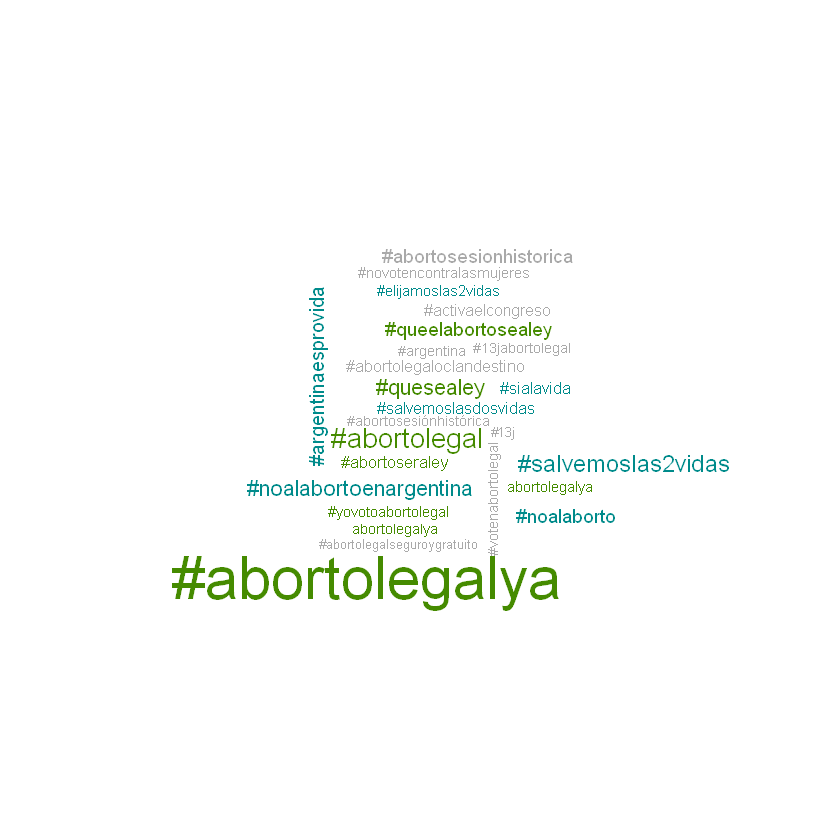

In [21]:
##NUBE DE HASH
hash$color[hash$pos == 1] <- "chartreuse4"
hash$color[hash$pos == 2] <- "cyan4"
hash$color[hash$pos == 0] <- "darkgray"
table(hash$color)
color <- hash$color

wordcloud(words = hash$tag,
          freq = hash$freq,
          scale = c(3,0.6),
          max.words = 25,
          colors = hash$color,
          ordered.colors = TRUE)

# 3 - Identificación de la posición del tweet frente a la sanción de la ley

Se busca identificar la posición del texto del tweet en función de la existencia de hashtags valorados en el punto anterior como a favor o en contra de la ley. En el análisis exploratorio se verificó que por un lado existen tweets que no contienen los hashtags más usados y por otro que también existen tweets con más de un hashtags de diferentes posiciones.

Se define dejar aquellos hashtags que representan más de un 1% del total de los hashtags identificados.

In [19]:
#Hash valorados dentro del texto.

hash$porc <- hash$freq/sum(hash$freq)*100
hash <- hash[hash$porc > 1, ]

v1 <- hash$tag[hash$pos == 1 & is.na(hash$pos) != T]
pattern_1 <- paste(v1, collapse = "|")

v2 <- hash$tag[hash$pos == 2 & is.na(hash$pos) != T]
pattern_2 <- paste(v2, collapse = "|")

tweets$hash_1 <- str_count(tweets$full_text, 
                                regex(pattern_1, ignore_case = TRUE, dotall = TRUE))

tweets$hash_2 <- str_count(tweets$full_text, 
                                regex(pattern_2, ignore_case = TRUE, dotall = TRUE))

table(tweets$hash_1, tweets$hash_2)

    
         0     1     2     3     4     5     6     7     8     9    10    20
  0  28887 32842 12595  2666   443    79    26     8    12     5    15     1
  1  92331  2020   369    71    30     2     1     0     0     0     0     0
  2  24132   295    71    15     3     0     0     0     0     0     0     0
  3   3306    63    21     2     1     1     0     0     0     0     0     0
  4    526    18     7     1     0     0     0     0     0     0     0     0
  5    113     3     0     0     0     0     0     0     0     0     0     0
  6     44     0     0     0     0     0     0     0     0     0     0     0
  7      9     0     0     0     0     0     0     0     0     0     0     0
  8      2     0     0     0     0     0     0     0     0     0     0     0
  9      2     0     0     0     0     0     0     0     0     0     0     0
  15     1     0     0     0     0     0     0     0     0     0     0     0
  16     1     0     0     0     0     0     0     0     0     0     0 

Como se mencionó previamente se verifican casos con la presencia de más du un hash de diferente posición. Como una primera aproximación a la valoración del tweet, se lo valora de acuerdo a el conteo máximo entre cada una de las posiciones. Es decir que si, por ejemplo, el tweet presenta dos hash valorados "en contra de la ley" y uno "a favor" de la misma se lo valora como en contra, en caso de empate el mismo queda sin identificar.

In [20]:
tweets$posicion_1 <- ifelse(tweets$hash_1 > tweets$hash_2, 1, 
                            ifelse(tweets$hash_1 < tweets$hash_2, 2, 0))

table(tweets$posicion_1, useNA = "always")

table(tweets$posicion, tweets$posicion_1, useNA = "always")


     0      1      2   <NA> 
 30980 120876  49185      0 

      
            0      1      2   <NA>
  no     1943    202  48138      0
  si     3213 119368    292      0
  <NA>  25824   1306    755      0

Se observan diferencias entre la voloración existente en la base y la asignada de acuerdo la valoración de los hashtags. Adicionalmente se verifica la existencia de casos sin valorar. <br>
En el análisis exploratorio, se observó que muchos de los usuarios presentaban su posición mediante emojis en la descripción del nombre o del cuerpo del tweet. Las posociones estaban fuertemente marcadas con corazones verdes para aquellos que se encontraban a favor de la sanción de la ley y corazones celestes para aquellos en contra, motivo pr el cual se buscó identificar estos patrones.

In [21]:
##Corazones en cuerpo del tweet y en usuario
# \U0001f49a #verde
# \U0001f499 #celeste

tweets$emoji_1 <- str_count(tweets$full_text, 
                           regex('\U0001f49a', ignore_case = TRUE, dotall = TRUE))

tweets$emoji_2 <- str_count(tweets$full_text, 
                            regex('\U0001f499', ignore_case = TRUE, dotall = TRUE))

tweets$emoji_u_1 <- str_count(tweets$user_name, 
                            regex('\U0001f49a', ignore_case = TRUE, dotall = TRUE))

tweets$emoji_u_2 <- str_count(tweets$user_name, 
                            regex('\U0001f499', ignore_case = TRUE, dotall = TRUE))

tweets$em <- ifelse(tweets$emoji_1 + tweets$emoji_u_1 > 
                      tweets$emoji_2 + tweets$emoji_u_2, 1,
                    ifelse(tweets$emoji_1 + tweets$emoji_u_1 < 
                             tweets$emoji_2 + tweets$emoji_u_2, 2, 0))

Al igual que en la identificación a través de los hashtags, se verificaron casos con la presencia de valoraciones distintas, pero en mucho menor medida. La identificación vía emojis pareciera ser más clara.

In [22]:
table(tweets$emoji_u_1, tweets$emoji_u_2)

table(tweets$em, useNA = "always")

    
          0      1      2      3      4      5      6      8     11     15
  0  168916   4211   1055    161     70     25      5      7      3      1
  1   21527     37      2      0      0      0      0      0      0      0
  2    4142      0      4      0      0      0      0      0      0      0
  3     548      2      0      0      0      0      0      0      0      0
  4     214      0      0      0      0      0      0      0      0      0
  5      41      0      0      0      0      0      0      0      0      0
  6      38      0      0      0      0      0      0      0      0      0
  7      15      0      0      0      0      0      0      0      0      0
  8      15      0      0      0      0      0      0      0      0      0
  10      1      0      0      0      0      0      0      0      0      0


     0      1      2   <NA> 
145370  48199   7471      1 

En base a la posición identificada por los emojis se dentifica la posición del texto para aquellos casos que no habían sido verifiados con anterioridad, es decir los casos en los que la pocisión se había marcado con "0".

In [23]:
tweets$posicion_1 <- ifelse(tweets$posicion_1 == 0 & tweets$em == 1, 1, 
                            ifelse(tweets$posicion_1 == 0 & tweets$em == 2, 2,
                                   tweets$posicion_1))

tweets$posicion_1[is.na(tweets$posicion_1)== T] <- 0

table(tweets$posicion_1, useNA = "always")



     0      1      2   <NA> 
 26027 124845  50169      0 

# 4 - Nube de palabras

A continuación se analizan las palabras más frecuentes dentro del cuerpo de los tweet.

In [24]:
##Nube todo el tweeet

myCorpus <- Corpus(VectorSource(tweets$full_text))
myCorpus <- tm_map(myCorpus, content_transformer(tolower))
myCorpus <- tm_map(myCorpus, removePunctuation) 
myCorpus <- tm_map(myCorpus, removeNumbers)
myCorpus <- tm_map(myCorpus, removeWords, stopwords('spanish'))

myCorpus <- tm_map(myCorpus, function(x) iconv(enc2utf8(x), sub = "byte"))

removeURL <- function(x) gsub("http[[:alnum:]]*", "", x)
myCorpus <- tm_map(myCorpus, content_transformer(removeURL))

tdm <- TermDocumentMatrix(myCorpus, 
                          control = list(wordLengths = c(1, 20)))
                   
tdm

Warning message in tm_map.SimpleCorpus(myCorpus, content_transformer(tolower)):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(myCorpus, removePunctuation):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(myCorpus, removeNumbers):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(myCorpus, removeWords, stopwords("spanish")):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(myCorpus, function(x) iconv(enc2utf8(x), :
"transformation drops documents"Warning message in tm_map.SimpleCorpus(myCorpus, content_transformer(removeURL)):
"transformation drops documents"ERROR while rich displaying an object: Error in nchar(Terms(x), type = "chars"): invalid multibyte string, element 5

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)


La matriz de términos del documento contiene la frecuencia con la que aparece cada palabra en el texto, dada la extensión del dataset se convierte en una matriz de gran extensión. R contiene una función que permite eliminar los términos con baja frecuencia o muy  "dispersos" (removeSparseTerms()), definiendo un umbral de la frecuencia relativa, por encima del cual el término se eliminará. 
Por ejemplo, si establece sparse = 0.99 como el argumento para removeSparseTerms(), se eliminarán solo los términos que sean más dispersos que 0.99, probablemente todos los términos quedarán retenidos.
En la matriz de término del conjunto de tweets, se verifica una dispersión muy alta, indicando la presencia de muchas palabras con muy poca frecuencia que no agregan valor al análisis que se está realizando y por lo tanto pueden ser excluídas. Se fija un sparse de 0.98.

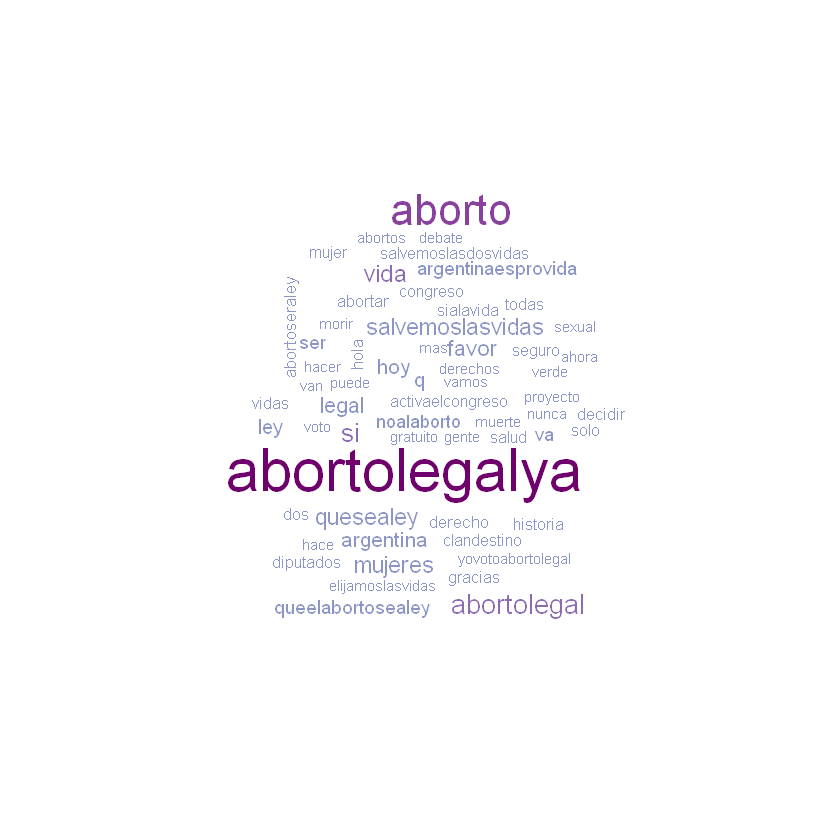

In [8]:
tdm <- removeSparseTerms(tdm, sparse = 0.98)

#freq.terms <- findFreqTerms(tdm, lowfreq=50)

m <- as.matrix(tdm)
m <- as.data.frame(m)
m <- sort(rowSums(m), decreasing=TRUE)
m <- data.frame(word=names(m), freq=m)

#elimino caracteres invalidos

m <- m %>% 
  filter(xfun::is_ascii(word)== T)

pal <- brewer.pal(8, "BuPu")
pal <- pal[-(1:4)]

wordcloud(words = m$word,
          freq = m$freq,
          scale = c(3,0.6),
          max.words = 60,
          colors = pal)

Por último se guarda la base reducida con las variabes que se utilizaron en el análisis.

In [25]:
base <- tweets[, c("id", "fecha", "full_text", "user_name", "user_id",
                   "base", "posicion", "posicion_1")]

save(base, file = paste(ruta, "base_tweets_final.Rda", sep=""))